In [1]:
import pandas as pd
from datetime import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Load the data

In [2]:
csvs = os.listdir('accepted/')

In [3]:
# make sure all csv files have the same headers
with open("accepted/"+csvs[0], 'r') as f:
    columns = f.readlines()[0]
for c in csvs[1:]:
    with open("accepted/" + c, 'r') as f:
        if f.readlines()[0] != columns:
            print(c)

In [4]:
dtype = {'id':str,'member_id':str,'loan_amnt':float,'funded_amnt':float,'funded_amnt_inv':float,
         'term':str,'int_rate':str,
         'installment':float,'grade':str,'sub_grade':str,'emp_title':str,'emp_length':str,'home_ownership':str,
         'annual_inc':float,'verification_status':str,'issue_d':str,'loan_status':str,'pymnt_plan':str,'url':str,
         'desc':str,'purpose':str,'title':str,'zip_code':str,'addr_state':str,'dti':float,'delinq_2yrs':float,
         'earliest_cr_line':str,'inq_last_6mths':float,'mths_since_last_delinq':float,
         'mths_since_last_record':float,
         'open_acc':float,'pub_rec':float,'revol_bal':float,'total_acc':float,'initial_list_status':str,
         'out_prncp':float,
         'out_prncp_inv':float,'total_pymnt':float,'total_pymnt_inv':float,'total_rec_prncp':float,
         'total_rec_int':float,
         'total_rec_late_fee':float,'recoveries':float,'collection_recovery_fee':float,'last_pymnt_d':str,
         'last_pymnt_amnt':float,'next_pymnt_d':str,'last_credit_pull_d':str,'collections_12_mths_ex_med':float,
         'mths_since_last_major_derog':float,'policy_code':str,'application_type':str,'annual_inc_joint':float,
         'dti_joint':float,'verification_status_joint':str,'acc_now_delinq':float,'tot_coll_amt':float,
         'tot_cur_bal':float,
         'open_acc_6m':float,'open_act_il':float,'open_il_12m':float,'open_il_24m':float,
         'mths_since_rcnt_il':float,'total_bal_il':float,
         'il_util':str,'open_rv_12m':float,'open_rv_24m':float,'max_bal_bc':float,'all_util':float,
         'total_rev_hi_lim':float,
         'inq_fi':float,'total_cu_tl':float,'inq_last_12m':float,'acc_open_past_24mths':float,'avg_cur_bal':float,
         'bc_open_to_buy':str,'bc_util':str,'chargeoff_within_12_mths':float,'delinq_amnt':float,
         'mo_sin_old_il_acct':str,
         'mo_sin_old_rev_tl_op':str,'mo_sin_rcnt_rev_tl_op':str,'mo_sin_rcnt_tl':str,'mort_acc':float,
         'mths_since_recent_bc':float,'mths_since_recent_bc_dlq':float,'mths_since_recent_inq':float,
         'mths_since_recent_revol_delinq':float,
         'num_accts_ever_120_pd':float,'num_actv_bc_tl':float,'num_actv_rev_tl':float,'num_bc_sats':float,
         'num_bc_tl':float,
         'num_il_tl':float,'num_op_rev_tl':float,'num_rev_accts':float,'num_rev_tl_bal_gt_0':float,'num_sats':float,
         'num_tl_120dpd_2m':float,'num_tl_30dpd':float,'num_tl_90g_dpd_24m':float,'num_tl_op_past_12m':float,
         'pct_tl_nvr_dlq':float,'percent_bc_gt_75':float,'pub_rec_bankruptcies':float,'tax_liens':float,
         'tot_hi_cred_lim':float,
         'total_bal_ex_mort':float,'total_bc_limit':float,'total_il_high_credit_limit':float,'revol_bal_joint':float,
         'sec_app_earliest_cr_line':str,'sec_app_inq_last_6mths':float,'sec_app_mort_acc':str,'sec_app_open_acc':str,
         'sec_app_revol_util':str,'sec_app_open_act_il':str,'sec_app_num_rev_accts':float,
         'sec_app_chargeoff_within_12_mths':float,
         'sec_app_collections_12_mths_ex_med':float,'sec_app_mths_since_last_major_derog':float,'hardship_flag':str,
         'hardship_type':str,'hardship_reason':str,'hardship_status':str,'deferral_term':str,'hardship_amount':float,
         'hardship_start_date':str,'hardship_end_date':str,'payment_plan_start_date':str,'hardship_length':str,
         'hardship_dpd':float,'hardship_loan_status':str,'orig_projected_additional_accrued_interest':float,
         'hardship_payoff_balance_amount':float,'hardship_last_payment_amount':float,'disbursement_method':str,
         'debt_settlement_flag':str,'debt_settlement_flag_date':str,'settlement_status':str,'settlement_date':str,
         'settlement_amount':float,'settlement_percentage':float,'settlement_term':str}

In [5]:
df = pd.DataFrame(columns=dtype.keys())
for i,c in enumerate(csvs):
    df = df.append(pd.read_csv("accepted/" + c, dtype=dtype))

In [6]:
print("number of data points: {}".format(len(df)))

number of data points: 1765451


### Drop current and unlabeled borrowers

In [7]:
print(df.loan_status.value_counts(normalize=True))

Current                                                0.523060
Fully Paid                                             0.357402
Charged Off                                            0.091091
Late (31-120 days)                                     0.014585
In Grace Period                                        0.009283
Late (16-30 days)                                      0.002981
Does not meet the credit policy. Status:Fully Paid     0.001126
Does not meet the credit policy. Status:Charged Off    0.000431
Default                                                0.000041
Name: loan_status, dtype: float64


We drop current borrowers, as we are primarily interested in those who have already paid off or charged off on their loans. We save the current borrowers to predict how they will behave for future projects. Note that "Charged Off" means no further payment is expected. This typically occurs when a payment is 150+ days past due. "Default" typically means the borrower has not made a payment for 121+ days, but the account has not been closed or sent to collections yet (see https://help.lendingclub.com/hc/en-us/articles/216127747-What-is-the-difference-between-a-loan-that-is-in-default-and-a-loan-that-has-been-charged-off-).

The labels that include "Does not meet the credit policy" means those applicants would not be awarded a loan under Lending Club's current policy. We omit them from this analysis, as we are concerned with the current policy of Lending Club.

In [8]:
# save current borrowers for separate analysis
current_df = df[(df.loan_status != 'Fully Paid') & (df.loan_status != 'Charged Off') 
                & (df.loan_status != 'Does not meet the credit policy. Status:Fully Paid')
                & (df.loan_status != 'Does not meet the credit policy. Status:Charged Off')]

In [9]:
current_df.to_csv("data/current_borrowers.csv", index=False)

We drop the unlabeled data points, as the proportion of unlabeled points (about .003%) is marginal.

In [10]:
print("number of unlabeled points: {}".format(len(df) - df.loan_status.value_counts().sum()))

number of unlabeled points: 25


In [11]:
# drop unlabeled data points (nan)
df = df.dropna(subset=['loan_status'])
len(df)

1765426

In [12]:
unqualified_df = df[df.loan_status.str.contains("Does not meet the credit policy")]
len(unqualified_df)

2749

In [13]:
# save those who don't meet the policy today in a separate csv
unqualified_df.to_csv("data/unqualified_df.csv", index=False)
df = df[(df.loan_status != 'Does not meet the credit policy. Status:Fully Paid') & 
        (df.loan_status != 'Does not meet the credit policy. Status:Charged Off')]
len(df)

1762677

In [14]:
# drop current borrowers
df = df[df.loan_status!='Current']
df = df[df.loan_status!='In Grace Period']
df = df[df.loan_status!='Late (31-120 days)']
df = df[df.loan_status!='Late (16-30 days)']
df = df[df.loan_status!='Default']

In [15]:
print(df.loan_status.unique())

['Fully Paid' 'Charged Off']


In [16]:
df.loan_status.value_counts(normalize=True)

Fully Paid     0.796896
Charged Off    0.203104
Name: loan_status, dtype: float64

Observations labeled with "Does not meet the credit policy" are people that borrowed from Lending Club in the past, but would not currently qualify for a loan under Lending Club's current policy. We save them as a separate dataframe for further analysis; perhaps we can identify the change in Lending Club's policy that would cause those borrowers to not qualify for a loan today.

### Label the data

In [17]:
df.loan_status = df.loan_status.map({'Fully Paid':1, 'Charged Off':0})
df.to_csv('data/labeled.csv', index=False)

In [18]:
# change loan_status to int, due to encoded labels
dtype['loan_status'] = int
df = pd.read_csv('data/labeled.csv', dtype=dtype)
len(df.columns)

145

### Remove features that are not available for new applicants

Since we want to this analysis to be useful for new applicants, we drop the columns that are available for only those whose applications have been accepted and have already received the loan for which they applied. Many of these features have to do with payment schedules, recovery fees, and hardship plans.

In [19]:
feats = ['collection_recovery_fee', 'funded_amnt', 'funded_amnt_inv', 'issue_d', 'last_credit_pull_d',
         'last_pymnt_amnt', 'last_pymnt_d', 'next_pymnt_d', 'out_prncp', 'out_prncp_inv', 'pymnt_plan',
         'recoveries', 'term', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee',
         'total_rec_prncp', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status',
         'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
         'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest',
         'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'disbursement_method', 
         'debt_settlement_flag', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
         'settlement_amount', 'settlement_percentage', 'settlement_term']
df.drop(feats, axis=1, inplace=True)

### Remove uniform columns

In [20]:
# find features with uniform values
for col in df.columns:
    if len(df[col].unique()) == 1:
        print(col, len(df[col].unique()))
        df.drop(col, axis=1, inplace=True)

id 1
member_id 1
policy_code 1
url 1


In [21]:
df.shape

(791781, 100)

### Remove columns with a majority (70% or more) of missing values

In [22]:
null_counts = dict(df.isnull().sum())
null_cols = []
for key,val in null_counts.items():
    if val/df.shape[0] >= .1:
        print("{:<35}\t{}".format((key), val/df.shape[0]))
    if val/df.shape[0] >= 0.7:
        null_cols.append(key)

all_util                           	0.7903877461065623
annual_inc_joint                   	0.995332042572378
desc                               	0.8491161066001837
dti_joint                          	0.995332042572378
il_util                            	0.8168483456915485
inq_fi                             	0.790373853376123
inq_last_12m                       	0.7903751163516174
max_bal_bc                         	0.790373853376123
mo_sin_old_il_acct                 	0.11224442112149698
mths_since_last_delinq             	0.5131620991157908
mths_since_last_major_derog        	0.7493372536092682
mths_since_last_record             	0.8365583412585046
mths_since_rcnt_il                 	0.7950165512938553
mths_since_recent_bc_dlq           	0.7683803981151354
mths_since_recent_inq              	0.1458370433238484
mths_since_recent_revol_delinq     	0.6752927892940094
num_tl_120dpd_2m                   	0.11655243053319037
open_acc_6m                        	0.7903751163516174
open_act_il 

We drop the variable `application_type` since it is nearly uniform.

In [23]:
df.application_type.value_counts(normalize=True)

Individual    0.995332
Joint App     0.004668
Name: application_type, dtype: float64

In [24]:
df.application_type.value_counts()

Individual    788085
Joint App       3696
Name: application_type, dtype: int64

In [25]:
df.drop('application_type', axis=1, inplace=True)

In [26]:
print(len(null_cols))
df.drop(null_cols, axis=1, inplace=True)
print(len(df.columns))

32
67


### Drop columns that aren't helpful or are strongly correlated with other features

In [27]:
df['zip_code'].head()

0    775xx
1    985xx
2    333xx
3    770xx
4    760xx
Name: zip_code, dtype: object

In [28]:
# drop the zip_code feature, since we can't work with 3-digit zip codes, and addr_state gives the state
df.drop("zip_code", axis=1, inplace=True)

In [29]:
df.drop('addr_state', axis=1, inplace=True)

In [30]:
df['title'].head(10)

0         Debt consolidation
1         Debt consolidation
2           Home improvement
3         Debt consolidation
4         Debt consolidation
5             Major purchase
6    Credit card refinancing
7      Moving and relocation
8         Debt consolidation
9                      Other
Name: title, dtype: object

In [31]:
# make lower case
df['title'] = df['title'].str.lower()
# got rid of about 10000 categories
print(len(df['title'].unique()))
print(df['title'].isnull().sum())

50798
7387


In [32]:
# keep top x categories
# use substring matching to combine categories (other ways to combine categories)
# make new categories for leftovers
print(len(df['title'].unique()))
df['title'].value_counts(normalize=True).iloc[:15]

50798


debt consolidation           0.482650
credit card refinancing      0.163981
home improvement             0.051340
other                        0.041199
major purchase               0.015564
consolidation                0.009329
medical expenses             0.008617
business                     0.008354
car financing                0.007036
debt consolidation loan      0.005771
vacation                     0.005375
moving and relocation        0.005240
credit card consolidation    0.004281
personal loan                0.004013
home buying                  0.003573
Name: title, dtype: float64

In [33]:
df['purpose'].value_counts(normalize=True)

debt_consolidation    0.590490
credit_card           0.214485
home_improvement      0.062402
other                 0.054115
major_purchase        0.021540
small_business        0.012631
car                   0.011061
medical               0.010753
moving                0.007041
vacation              0.006292
house                 0.005166
wedding               0.002868
renewable_energy      0.000744
educational           0.000412
Name: purpose, dtype: float64

In [34]:
# drop title (for now), as purpose is a more uniform, consistent way to measure a similar thing (high correlation)
df.drop('title', axis=1, inplace=True)

In [35]:
df.emp_title.head()

0             Buyer
1               USA
2               NaN
3               NaN
4    member service
Name: emp_title, dtype: object

In [36]:
len(df.emp_title.unique())

275475

In [37]:
# for similar reasoning, drop emp_title (user input, very messy)
df.drop('emp_title', axis=1, inplace=True)

In [38]:
df.grade.value_counts(normalize=True)

B    0.288935
C    0.276340
A    0.163899
D    0.156993
E    0.078034
F    0.028402
G    0.007397
Name: grade, dtype: float64

In [39]:
df.sub_grade.value_counts(normalize=True)

B3    0.063241
B4    0.062870
C1    0.061520
C2    0.058502
B5    0.058317
B2    0.054934
C3    0.054861
C4    0.053442
B1    0.049573
C5    0.048016
A5    0.046678
D1    0.040097
A4    0.038796
D2    0.034604
D3    0.030087
D4    0.028502
A1    0.026889
A3    0.026525
A2    0.025011
D5    0.023704
E1    0.020006
E2    0.018178
E3    0.015271
E4    0.013143
E5    0.011438
F1    0.008730
F2    0.006488
F3    0.005491
F4    0.004294
F5    0.003399
G1    0.002464
G2    0.001841
G3    0.001321
G4    0.000976
G5    0.000794
Name: sub_grade, dtype: float64

In [40]:
df.grade = df.sub_grade.apply(lambda x: x[0] if x[0]=='E' or x[0]=='F' or x[0]=='G' else x)

In [41]:
df.grade.value_counts(normalize=True)

E     0.078034
B3    0.063241
B4    0.062870
C1    0.061520
C2    0.058502
B5    0.058317
B2    0.054934
C3    0.054861
C4    0.053442
B1    0.049573
C5    0.048016
A5    0.046678
D1    0.040097
A4    0.038796
D2    0.034604
D3    0.030087
D4    0.028502
F     0.028402
A1    0.026889
A3    0.026525
A2    0.025011
D5    0.023704
G     0.007397
Name: grade, dtype: float64

In [42]:
# drop sub_grade, as that information can be captured in our engineered grade
df.drop('sub_grade', axis=1, inplace=True)

### Clean features and change to floats/ints

In [43]:
df['revol_util'].head()

0    50.9%
1    45.6%
2    11.9%
3       5%
4    92.6%
Name: revol_util, dtype: object

In [44]:
# change revol_util to floats
df.revol_util = df.revol_util.str[:-1].astype('float')/100
df.revol_util.head()

0    0.509
1    0.456
2    0.119
3    0.050
4    0.926
Name: revol_util, dtype: float64

In [45]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line']).dt.year

We keep interest rate, as it is calculated based off the grade which Lending Club gives an applicant. The method of grade assignment is explained in this link: https://www.lendingclub.com/foliofn/rateDetail.action.

In [46]:
df['int_rate'].head()

0     13.99%
1     14.49%
2      5.32%
3     12.79%
4     13.99%
Name: int_rate, dtype: object

In [47]:
df.int_rate = df.int_rate.str[:-1].astype('float')/100
df.int_rate.head()

0    0.1399
1    0.1449
2    0.0532
3    0.1279
4    0.1399
Name: int_rate, dtype: float64

In [48]:
df.bc_util = df.bc_util.astype('float')

In [49]:
df.bc_util.tail(10)

791771    76.3
791772    44.4
791773    22.2
791774    70.0
791775    78.7
791776    55.6
791777    24.6
791778     NaN
791779    18.2
791780    13.1
Name: bc_util, dtype: float64

In [50]:
df.bc_open_to_buy = df.bc_open_to_buy.astype('float')

In [51]:
df.dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('O')], dtype=object)

In [52]:
df.select_dtypes(include=['O']).columns

Index(['emp_length', 'grade', 'home_ownership', 'initial_list_status',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'purpose', 'verification_status'],
      dtype='object')

In [53]:
df['emp_length'].head()

0      4 years
1    10+ years
2          n/a
3          n/a
4    10+ years
Name: emp_length, dtype: object

In [54]:
df['emp_length'] = df['emp_length'].apply(lambda x: -1 if x=='n/a' else 0 if x[0]=='<' else int(x[0]))

In [55]:
df['grade'].astype('category').cat.codes.value_counts(normalize=True)

20    0.078034
7     0.063241
8     0.062870
10    0.061520
11    0.058502
9     0.058317
6     0.054934
12    0.054861
13    0.053442
5     0.049573
14    0.048016
4     0.046678
15    0.040097
3     0.038796
16    0.034604
17    0.030087
18    0.028502
21    0.028402
0     0.026889
2     0.026525
1     0.025011
19    0.023704
22    0.007397
dtype: float64

In [56]:
df['grade'] = df['grade'].astype('category').cat.codes

In [58]:
df['home_ownership'].value_counts(normalize=True)

MORTGAGE    0.499499
RENT        0.398807
OWN         0.101346
OTHER       0.000182
ANY         0.000111
NONE        0.000054
Name: home_ownership, dtype: float64

In [60]:
ownership_dict = {'MORTGAGE':0, 'RENT': 1, 'OWN': 2, 'OTHER': 3, 'ANY': 4, 'NONE': 5}
df.home_ownership = df.home_ownership.map(ownership_dict)

In [61]:
df['initial_list_status'].value_counts(normalize=True)

f    0.511563
w    0.488437
Name: initial_list_status, dtype: float64

In [63]:
df['initial_list_status'] = df['initial_list_status'].astype('category').cat.codes

In [78]:
df['mo_sin_old_il_acct'] = df['mo_sin_old_il_acct'].astype(float)
df['mo_sin_old_rev_tol_op'] = df['mo_sin_old_rev_tl_op'].astype(float)
df['mo_sin_rcnt_rev_tl_op'] = df['mo_sin_rcnt_rev_tl_op'].astype(float)
df['mo_sin_rcnt_tl'] = df['mo_sin_rcnt_tl'].astype(float)
df['mo_sin_old_rev_tl_op'] = df['mo_sin_old_rev_tl_op'].astype(float)

In [69]:
df['purpose'].value_counts(normalize=True)

debt_consolidation    0.590490
credit_card           0.214485
home_improvement      0.062402
other                 0.054115
major_purchase        0.021540
small_business        0.012631
car                   0.011061
medical               0.010753
moving                0.007041
vacation              0.006292
house                 0.005166
wedding               0.002868
renewable_energy      0.000744
educational           0.000412
Name: purpose, dtype: float64

In [72]:
df['purpose'].astype('category').cat.codes.value_counts(normalize=True)

2     0.590490
1     0.214485
4     0.062402
9     0.054115
6     0.021540
11    0.012631
0     0.011061
7     0.010753
8     0.007041
12    0.006292
5     0.005166
13    0.002868
10    0.000744
3     0.000412
dtype: float64

In [73]:
df['purpose'] = df['purpose'].astype('category').cat.codes

In [74]:
df['verification_status'].value_counts(normalize=True)

Source Verified    0.359320
Verified           0.331655
Not Verified       0.309025
Name: verification_status, dtype: float64

In [75]:
df['verification_status'] = df['verification_status'].astype('category').cat.codes

In [79]:
df.dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('int8')], dtype=object)

In [70]:
print(df.columns[df.isnull().any()], len(df.columns[df.isnull().any()]))

Index(['acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'dti',
       'inq_last_6mths', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_last_delinq', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
       'revol_util', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'total_rev_hi_lim'],
      dtype='object') 43


In [80]:
# save the work we've done thus far
df.to_csv("data/cleaned_features.csv", index=False)

### Create train/test split and fill missing values

In [81]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('loan_status', axis=1), df['loan_status'], test_size=.25)

In [101]:
df.annual_inc.max(), df.annual_inc.min()

(9550000.0, 0.0)

In [102]:
df[df['annual_inc']==9550000]['verification_status']

22303    Source Verified
Name: verification_status, dtype: object

In [107]:
X_train['annual_inc'].max()

9550000.0

In [108]:
X_train['annual_inc'].describe()

count    5.938350e+05
mean     7.524301e+04
std      6.634302e+04
min      0.000000e+00
25%      4.513100e+04
50%      6.500000e+04
75%      9.000000e+04
max      9.550000e+06
Name: annual_inc, dtype: float64

In [111]:
X_train['annual_inc'].nlargest(30)

22303     9550000.0
217264    8900060.0
400544    8706582.0
64766     8300000.0
85911     8253000.0
94571     7500000.0
221288    7446395.0
95648     7200000.0
134706    7141778.0
38507     7000000.0
111737    6998721.0
51033     6500000.0
209282    6000000.0
36608     6000000.0
30176     6000000.0
124124    5604824.0
181428    5000000.0
76129     4900000.0
131117    4860012.0
71757     4647200.0
44470     4300012.0
105356    4300000.0
112038    4000095.0
7017      3964280.0
29708     3900000.0
103645    3200000.0
19457     3000000.0
61600     3000000.0
63573     2500000.0
39874     2300000.0
Name: annual_inc, dtype: float64

In [115]:
len(X_train[X_train['annual_inc']>500000])

682

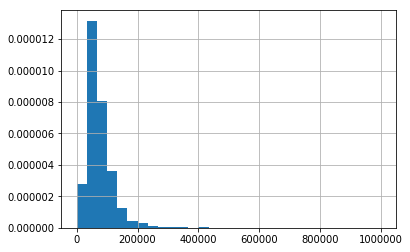

In [113]:
X_train[X_train['annual_inc']<1000000]['annual_inc'].hist(bins=30, normed=True)
plt.show()

In [96]:
# find column with most missing values
X_train.count().idxmin()

'mths_since_recent_revol_delinq'

In [97]:
X_train['mths_since_recent_revol_delinq'].isnull().sum()/X_train.shape[0]

0.67471267271211699

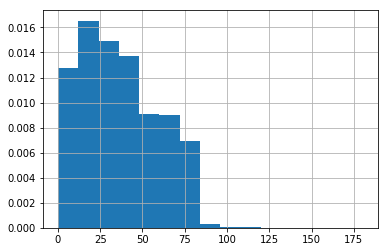

In [98]:
X_train.mths_since_recent_revol_delinq.hist(bins=15, normed=True)
plt.show()

In [117]:
X_train.shape

(593835, 61)

In [116]:
X_train.mths_since_recent_revol_delinq.describe()

count    193167.000000
mean         36.236236
std          22.465860
min           0.000000
25%          17.000000
50%          33.000000
75%          53.000000
max         180.000000
Name: mths_since_recent_revol_delinq, dtype: float64

In [28]:
df[~df.mths_since_recent_revol_delinq.isnull()].loan_status.value_counts(normalize=True)

1    0.787708
0    0.212292
Name: loan_status, dtype: float64

In [29]:
df[df.mths_since_recent_revol_delinq.isnull()].loan_status.value_counts(normalize=True)

1    0.799891
0    0.200109
Name: loan_status, dtype: float64

In [31]:
# Fill with median, since "mths_since_recent_revol_delinq" is integer-valued, and slightly skewed left
df["mths_since_recent_revol_delinq"].fillna(df["mths_since_recent_revol_delinq"].median(), inplace=True)

In [33]:
# find column with most missing values
col = df.count().idxmin()
print(col)
df[col].isnull().sum()/df.shape[0]

mths_since_last_delinq


0.5129748321508801

In [34]:
df[~df.mths_since_last_delinq.isnull()].loan_status.value_counts(normalize=True)

1    0.789061
0    0.210939
Name: loan_status, dtype: float64

In [35]:
df[df.mths_since_last_delinq.isnull()].loan_status.value_counts(normalize=True)

1    0.802458
0    0.197542
Name: loan_status, dtype: float64

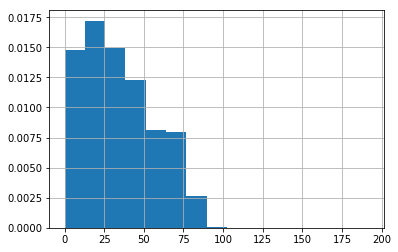

In [36]:
df.mths_since_last_delinq.hist(bins=15, normed=True)
plt.show()

In [37]:
df['mths_since_last_delinq'].describe()

count    383732.000000
mean         34.524348
std          21.946122
min           0.000000
25%          16.000000
50%          31.000000
75%          50.000000
max         192.000000
Name: mths_since_last_delinq, dtype: float64

In [40]:
# Fill with median, since "mths_since_last_delinq" is integer-valued, and slightly skewed left
df["mths_since_last_delinq"].fillna(df["mths_since_last_delinq"].median(), inplace=True)

In [41]:
df.acc_open_past_24mths.describe()

count    740629.000000
mean          4.712176
std           3.146878
min           0.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          56.000000
Name: acc_open_past_24mths, dtype: float64

In [42]:
# fill with median since months since is nominal and median and mean are close (not so much skew)
df['acc_open_past_24mths'].fillna(df['acc_open_past_24mths'].median(), inplace=True)

In [43]:
df['avg_cur_bal'].describe()

count    720371.000000
mean      13528.413955
std       16219.021791
min           0.000000
25%        3118.000000
50%        7516.000000
75%       18845.000000
max      958084.000000
Name: avg_cur_bal, dtype: float64

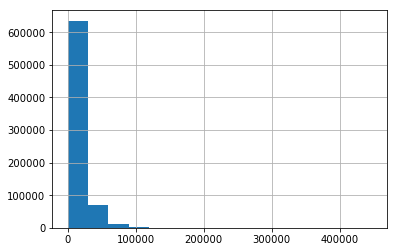

In [44]:
df[df['avg_cur_bal']<463698]['avg_cur_bal'].hist(bins=15)
plt.show()

In [45]:
df[df['avg_cur_bal']<10000].shape

(408615, 64)

In [46]:
# since over 50% of the data is contained when avg_cur_bal < 10000, we fill missing values with median
df['avg_cur_bal'].fillna(df['avg_cur_bal'].median(), inplace=True)

In [47]:
df['bc_open_to_buy'].describe()

count    733034.000000
mean       9436.288340
std       14551.612378
min           0.000000
25%        1304.000000
50%        4240.000000
75%       11299.000000
max      559912.000000
Name: bc_open_to_buy, dtype: float64

In [48]:
# drop bc_open_to_buy because it means "total open-to-buy on revolving bankcards"
# information can be found in (I think) in tot_hi_cred_lim
df.drop('bc_open_to_buy', axis=1, inplace=True)

In [49]:
df['bc_util'].describe()

count    732567.000000
mean         61.644117
std          27.863545
min           0.000000
25%          40.900000
50%          65.500000
75%          86.000000
max         339.600000
Name: bc_util, dtype: float64

In [50]:
# fill with mean (data is not very skewed)
df['bc_util'].fillna(df['bc_util'].mean(), inplace=True)

In [51]:
df['inq_last_6mths'].value_counts()

0.0    427576
1.0    220004
2.0     89382
3.0     36329
4.0     10071
5.0      3577
6.0       900
7.0        48
8.0        22
Name: inq_last_6mths, dtype: int64

In [52]:
# fill with median due to integer values
df['inq_last_6mths'].fillna(df['inq_last_6mths'].median(), inplace=True)

In [53]:
df['dti'].describe()

count    787881.000000
mean         17.832820
std           8.845265
min          -1.000000
25%          11.610000
50%          17.320000
75%          23.580000
max         999.000000
Name: dti, dtype: float64

In [55]:
df[df['dti']==-1]

,acc_open_past_24mths,addr_state,annual_inc,avg_cur_bal,bc_util,collection_recovery_fee,delinq_2yrs,dti,emp_length,funded_amnt,...,total_acc,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,total_pymnt,total_rec_int,total_rec_prncp,total_rev_hi_lim,verification_status,credit_pull_time_diff
645411,8.0,OR,94000.0,8461.0,61.7,0.0,0.0,-1.0,5 years,15000.0,...,24.0,93070.0,10300.0,94043.0,16188.78,1188.78,15000.0,33700.0,Source Verified,170


In [56]:
# fill with mean; data is not skewed
# there is only one value of -1, I thought was impossible and placeholder for NaN
# however, maybe it's possible?
df['dti'].fillna(df['dti'].mean(), inplace=True)

In [57]:
df['mort_acc'].describe()

count    740629.000000
mean          1.764267
std           2.087446
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          51.000000
Name: mort_acc, dtype: float64

In [58]:
# fill with median (integer-valued)
df['mort_acc'].fillna(df['mort_acc'].median(), inplace=True)

In [60]:
df[df['num_bc_sats'] != df['num_bc_tl']][['num_bc_sats','num_bc_tl']].shape

(672965, 2)

In [61]:
# drop num_bc_tl because (I believe) it's more important than num_bc_sats, and has more missing values
df.drop('num_bc_sats', axis=1, inplace=True)

In [62]:
(df['pub_rec_bankruptcies'] == df['pub_rec']).sum()

748576

In [64]:
df[df['pub_rec_bankruptcies'] != df['pub_rec']]['loan_status'].value_counts(normalize=True)

1    0.758987
0    0.241013
Name: loan_status, dtype: float64

In [66]:
df[(df['pub_rec_bankruptcies'] != df['pub_rec']) & (df['pub_rec_bankruptcies'] > df['pub_rec'])][['pub_rec_bankruptcies','pub_rec']]

,pub_rec_bankruptcies,pub_rec


In [68]:
# Drop pub_rec_bankruptcies, since that information is captured in pub_rec
df.drop('pub_rec_bankruptcies', axis=1, inplace=True)

In [69]:
df['revol_util'].describe()

count    787436.000000
mean          0.530831
std           0.243244
min           0.000000
25%           0.351000
50%           0.538000
75%           0.719000
max           8.923000
Name: revol_util, dtype: float64

In [70]:
# Fill with mean (not skewed) - could figure this out using other variables later
df['revol_util'].fillna(df['revol_util'].mean(), inplace=True)

In [71]:
# drop because 76% are 0, and the remaining have the same distribution of labels as total sample
df.drop("num_accts_ever_120_pd", axis=1, inplace=True)

In [72]:
df['num_actv_bc_tl'].describe()

count    720383.000000
mean          3.635744
std           2.187278
min           0.000000
25%           2.000000
50%           3.000000
75%           5.000000
max          33.000000
Name: num_actv_bc_tl, dtype: float64

In [73]:
# fill with median (integer-valued)
df['num_actv_bc_tl'].fillna(df['num_actv_bc_tl'].median(), inplace=True)

In [74]:
# fill with median (integer-valued)
df['num_actv_rev_tl'].fillna(df['num_actv_rev_tl'].median(), inplace=True)

In [75]:
# fill with median (integer-valued)
df['num_bc_tl'].fillna(df['num_bc_tl'].median(), inplace=True)

In [76]:
# fill with rounded-down mean
df['num_il_tl'].fillna(np.floor(df['num_il_tl'].median()), inplace=True)

In [77]:
# fill with rounded-down mean
df['num_op_rev_tl'].fillna(np.floor(df['num_op_rev_tl'].mean()), inplace=True)

In [78]:
df['num_rev_accts'].fillna(np.floor(df['num_rev_accts'].mean()), inplace=True)

In [79]:
df['num_rev_tl_bal_gt_0'].fillna(df['num_rev_tl_bal_gt_0'].median(), inplace=True)

In [80]:
df['num_sats'].fillna(df['num_sats'].median(), inplace=True)

In [81]:
df['num_tl_op_past_12m'].fillna(df['num_tl_op_past_12m'].median(), inplace=True)

In [82]:
df['pct_tl_nvr_dlq'].describe()

count    720248.000000
mean         94.398238
std           8.384764
min           0.000000
25%          91.700000
50%          98.100000
75%         100.000000
max         100.000000
Name: pct_tl_nvr_dlq, dtype: float64

In [83]:
df['pct_tl_nvr_dlq'].fillna(df['pct_tl_nvr_dlq'].median(), inplace=True)

In [84]:
df['percent_bc_gt_75'].describe()

count    732760.000000
mean         47.331868
std          35.624645
min           0.000000
25%          16.700000
50%          50.000000
75%          75.000000
max         100.000000
Name: percent_bc_gt_75, dtype: float64

In [85]:
df['percent_bc_gt_75'].fillna(df['percent_bc_gt_75'].median(), inplace=True)

In [86]:
# fill with median because of outliers
df['tot_cur_bal'].fillna(df['tot_cur_bal'].median(), inplace=True)

In [87]:
# fill with median because of outliers
df['tot_hi_cred_lim'].fillna(df['tot_hi_cred_lim'].median(), inplace=True)

In [88]:
# fill with median because of outliers
df['total_bal_ex_mort'].fillna(df['total_bal_ex_mort'].median(), inplace=True)

In [89]:
# fill with median because of outliers
df['total_bc_limit'].fillna(df['total_bc_limit'].median(), inplace=True)

In [90]:
# fill with median because of outliers
df['total_il_high_credit_limit'].fillna(df['total_il_high_credit_limit'].median(), inplace=True)

In [91]:
# fill with median because of outliers
df['total_rev_hi_lim'].fillna(df['total_rev_hi_lim'].median(), inplace=True)

In [39]:
months_cols = ['mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
               'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
               'mths_since_recent_bc', 'mths_since_recent_inq',]
df[months_cols].isnull().sum()/df.shape[0]

mo_sin_old_il_acct       0.112674
mo_sin_old_rev_tl_op     0.085705
mo_sin_rcnt_rev_tl_op    0.085705
mo_sin_rcnt_tl           0.085704
mths_since_recent_bc     0.068910
mths_since_recent_inq    0.146151
dtype: float64

In [92]:
df.isnull().sum()

acc_open_past_24mths                   0
addr_state                             0
annual_inc                             0
avg_cur_bal                            0
bc_util                                0
collection_recovery_fee                0
delinq_2yrs                            0
dti                                    0
emp_length                             0
funded_amnt                            0
funded_amnt_inv                        0
grade                                  0
home_ownership                         0
initial_list_status                    0
inq_last_6mths                         0
installment                            0
int_rate                               0
last_pymnt_amnt                        0
loan_amnt                              0
loan_status                            0
mo_sin_old_il_acct                 88777
mo_sin_old_rev_tl_op               67528
mo_sin_rcnt_rev_tl_op              67528
mo_sin_rcnt_tl                     67527
mort_acc        

In [ ]:
len(df.columns)

In [ ]:
df.to_csv("cleaned_data.csv", index=False)

## SCRATCH

In [ ]:
# MAYBE only keep the first 6 categories of this feature? due to dist.
df.mort_acc.value_counts(normalize=True)